## RL and Advanced DL: Домашнее задание 1

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from joblib import Parallel, delayed
import gym
env = gym.make('Blackjack-v1')

### Part1

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
EXELENT_NUMBERS = [19, 20, 21]
average_reward = 0
N = 100000

def test_naive(env):
    (player_score, dealer_card, usable_ace), _ = env.reset()
    done = False
    while not done:
        if player_score in EXELENT_NUMBERS:
            (player_score, dealer_card, usable_ace), reward, done, _, _ = env.step(0)
        else:
            (player_score, dealer_card, usable_ace), reward, done, _, _ = env.step(1)
    return reward

average_reward = np.mean(Parallel(n_jobs=-1)(delayed(test_naive)(env) for _ in range(N)))
print(average_reward)

-0.19967


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [3]:
EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 23
NUM_ACTIONS = 2
Q_values = np.array([[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)])
Returns = [[[] for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]

In [4]:
testing_avg_reward = []

N_iters = 1_000_000
# Monte Carlo control
for i in trange(N_iters):
    
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / N_iters
    # generate episode
    episode = []
    (player_score, dealer_card, usable_ace), _ = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
        episode.append((player_score, action, reward, done))
        player_score = player_score_next
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done in episode[::-1]:
        G = reward + G
        if not Returns[player_score][action]:
            Returns[player_score][action] = (G, 1)
        else:
            value, count = Returns[player_score][action]
            Returns[player_score][action] = ((G + value * count) / (count + 1), count + 1)
        
        Q_values[player_score, action] = Returns[player_score][action][0]
    
    
    # testing model  every 5000 iterations
    if i % 5000 == 0:
        def test_monte_carlo(env, Q_values):
            (player_score, dealer_card, usable_ace), _ = env.reset()
            done = False
            while not done:
                if random.uniform(0, 1) > EPSILON:
                    action = np.argmax(Q_values[player_score])
                else:
                    action = random.randint(0, 1)
                (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
                player_score = player_score_next
            return reward
        
        average_reward = np.mean(Parallel(n_jobs=-1)(
            delayed(test_monte_carlo)(env, Q_values) for _ in range(N))
                                )
        testing_avg_reward.append(average_reward)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [13:05<00:00, 1273.55it/s]


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

**Основной гиперпараметр EPSILON**. Гамма не влияет, а количество итераций берем большое (на каждое состояние от 4 до 22 много состояний при N > 100000).

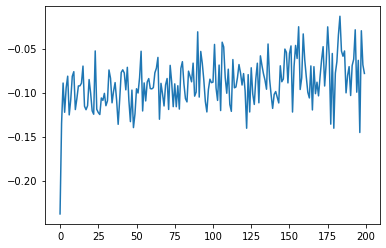

In [5]:
# Средняя награда по итерациям (*5000)
plt.plot(testing_avg_reward)

In [6]:
print('Средняя награда за 100_000 эпизодов', np.mean(testing_avg_reward[-10:]))

Средняя награда за 100_000 эпизодов -0.074724


### Part2

In [3]:
class BlackJackWithDouble:
    def __init__(self, env):
        self.env = env
    def reset(self):
        return self.env.reset()
    def step(self, action):
        if action == 2:
            (state, d_state, ace), r, done, info1, info2 =  self.env.step(1)
            while not done:
                (state, d_state, ace), r, done, info1, info2 =  self.env.step(0)
            return (state, d_state, ace), 2 * r, done, info1, info2
        return self.env.step(action)

In [4]:
new_env = BlackJackWithDouble(env)

In [5]:
EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 40
NUM_ACTIONS = 3
Q_values = np.array([[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)])
Returns = [[[] for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]

In [10]:
testing_avg_reward = []


N_iters = 1_000_000
# Monte Carlo control
for i in trange(N_iters):
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / N_iters
    # generate episode
    episode = []
    (player_score, dealer_card, usable_ace), _ = new_env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 2)
        (player_score_next, dealer_card, usable_ace), reward, done, _, _ = new_env.step(action)
        episode.append((player_score, action, reward, done))
        player_score = player_score_next
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done in episode[::-1]:
        G = reward + G
        if not Returns[player_score][action]:
            Returns[player_score][action] = (G, 1)
        else:
            value, count = Returns[player_score][action]
            Returns[player_score][action] = ((G + value * count) / (count + 1), count + 1)
        
        Q_values[player_score, action] = Returns[player_score][action][0]


    # testing model  every 5000 iterations
    if i % 5000 == 0:
        def test_monte_carlo(env, Q_values):
            (player_score, dealer_card, usable_ace), _ = env.reset()
            done = False
            while not done:
                if random.uniform(0, 1) > EPSILON:
                    action = np.argmax(Q_values[player_score])
                else:
                    action = random.randint(0, 1)
                (player_score_next, dealer_card, usable_ace), reward, done, _, _ = env.step(action)
                player_score = player_score_next
            return reward
        average_reward = np.mean(
            Parallel(n_jobs=-1)(delayed(test_monte_carlo)(new_env, Q_values) for _ in range(N))
        )
        testing_avg_reward.append(average_reward)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [12:55<00:00, 1289.68it/s]


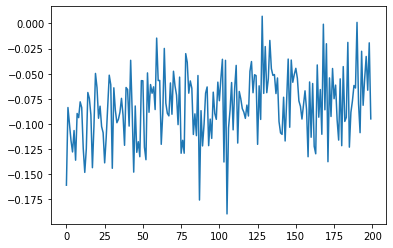

In [11]:
# Средняя награда по итерациям (*5000)
plt.plot(testing_avg_reward)

In [12]:
print('Средняя награда за 100_000 эпизодов', np.mean(testing_avg_reward[-10:]))

Средняя награда за 100_000 эпизодов -0.056431999999999996


__Видно что удвоение ставки повышает среднюю награду, но она все равно ниже нуля. Казино выигрывает!!!!__

### Part3

In [3]:
from gym.envs.toy_text import BlackjackEnv
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

In [4]:
def cmp(a, b):
    return float(a > b) - float(a < b)


def draw_card(card_count):
    counts = [count_ for count_ in card_count.values()]
    keys = [key_ for key_ in card_count.keys()]
    probs = [count_ / sum(counts) for count_ in counts]
    return np.random.choice(keys, p=probs)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class BlackJackWithFiniteDeck(BlackjackEnv):
    def __init__(self):
        super(BlackJackWithFiniteDeck, self).__init__()
        self.card_count = {2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 
                           7: 4, 8: 4, 9: 4, 10: 16, 1: 4}
        self.limit = 15
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            card_cur = draw_card(self.card_count)
            self.card_count[card_cur] -= 1
            self.player.append(card_cur)
            
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                card_cur = draw_card(self.card_count)
                self.card_count[card_cur] -= 1
                self.dealer.append(card_cur)
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, self.card_count
    
    def draw_hand(self):
        card_first = draw_card(self.card_count)
        self.card_count[card_first] -= 1
        card_second = draw_card(self.card_count)
        self.card_count[card_second] -= 1
        return [card_first, card_second]
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None, ):
        
        # reset deck
        if sum(self.card_count.values()) < self.limit:
            self.card_count = {2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 
                           7: 4, 8: 4, 9: 4, 10: 16, 1: 4}
        
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
 

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), self.card_count

In [5]:
custom_env = BlackJackWithFiniteDeck()

In [6]:
# Как и в системе счёта десяток, каждой карте, выходящей из колоды, присваивается своё числовое значение:

# Карты 	Числовые значения
# 2, 3, 4, 5, 6 	+1
# 7, 8, 9       	0
# 10, В, Д, К, Т	−1

ETALON = {2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 16, 1: 4}
PRICES = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
def get_index_from_card_count(card_count):
    return 37 + sum([(ETALON[card] - card_count[card]) * PRICES[card] for card in card_count])

In [17]:
# МЕТОД ИЗ 2 ПУНКТА
# БЕЗ ПОДСЧЕТА КАРТ ДЛЯ ВАЛИДАЦИИ и СРАВНЕНИЯ

EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 23
NUM_ACTIONS = 2
Q_values = np.array(
    [[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]
)
Returns = [[[]  for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)]
testing_avg_reward = []

N_ITERS = 1_000_000
# Monte Carlo control
for i in trange(N_ITERS):
    
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / N_ITERS
    # generate episode
    episode = []
    (player_score, dealer_card, _), card_count_ = custom_env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, _), reward, done, _, card_count_ = custom_env.step(action)
        episode.append((player_score, action, reward, done, card_count_))
        player_score = player_score_next
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done, card_count_ in episode[::-1]:
        G = reward + G
        if not Returns[player_score][action]:
            Returns[player_score][action] = (G, 1)
        else:
            value, count = Returns[player_score][action]
            Returns[player_score][action] = ((value * count + G)/(count + 1), count + 1)
        
        Q_values[player_score, action] =\
            Returns[player_score][action][0]


average_reward = 0
for i in range(N):
    (player_score, dealer_card, _), card_count_ = custom_env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, _), reward, done, _, card_count_ = custom_env.step(action)
        player_score = player_score_next
    average_reward += reward
print('Средняя награда без учета подсчета карт', average_reward / N)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [05:53<00:00, 2830.78it/s]


Средняя награда без учета подсчета карт -0.07771


In [7]:
#### МОДЕЛЬ с учетом системы плюс минус как в фильме "21"
EPSILON_INIT = 0.1
EPSILON_END = 0.001
NUM_STATES = 23
NUM_ACTIONS = 2
MAX_INDEXES = 75
Q_values = np.array(
    [[[0. for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)] for k in range(MAX_INDEXES)]
)
Returns = [[[[]  for i in range(NUM_ACTIONS)] for j in range(NUM_STATES)] for k in range(MAX_INDEXES)]

In [9]:
testing_avg_reward = []

memory_function = get_index_from_card_count


N_ITERS = 1_000_000
# Monte Carlo control
for i in trange(N_ITERS):
    
    EPSILON = EPSILON_INIT - i * (EPSILON_INIT - EPSILON_END) / N_ITERS
    # generate episode
    episode = []
    (player_score, dealer_card, _), card_count_ = custom_env.reset()
    index_ = memory_function(card_count_)
    done = False
    while not done:
        if random.uniform(0, 1) > EPSILON:
            action = np.argmax(Q_values[index_][player_score])
        else:
            action = random.randint(0, 1)
        (player_score_next, dealer_card, _), reward, done, _, next_card_count_ = custom_env.step(action)
        episode.append((player_score, action, reward, done, index_))
        player_score = player_score_next
        index_ = memory_function(next_card_count_)
    
    # calculate new q_matrix
    G = 0
    for player_score, action, reward, done, index_ in episode[::-1]:
        G = reward + G
        
        
        if not Returns[index_][player_score][action]:
            Returns[index_][player_score][action] = (G, 1)
        else:
            value, count = Returns[index_][player_score][action]
            value = (value * count + G) / (count + 1)
            Returns[index_][player_score][action] = (value, count + 1)

        Q_values[index_][player_score, action] =\
            Returns[index_][player_score][action][0]
    
  
    # testing model  every 5000 iterations
    if i%5000==0:
        average_reward = 0
        for _ in range(N):
            (player_score, dealer_card, _), card_count_ = env.reset()
            index_ = memory_function(card_count_)
            done = False
            while not done:
                if random.uniform(0, 1) > EPSILON:
                    action = np.argmax(Q_values[index_][player_score])
                else:
                    action = random.randint(0, 1)
                (player_score_next, next_dealer_card, _), reward, done, _, next_card_count_ = env.step(action)
                player_score = player_score_next
                dealer_card = next_dealer_card
                index_ = memory_function(next_card_count_)
            average_reward += reward
        
        testing_avg_reward.append(average_reward / N)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [34:06<00:00, 488.61it/s]


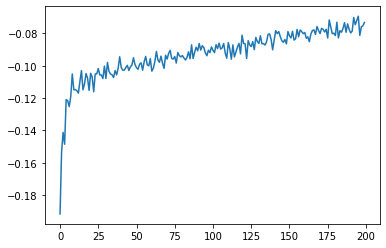

In [10]:
# Средняя награда по итерациям (*5000)
plt.plot(testing_avg_reward)

In [11]:
print('Средняя награда с учетом подсчета карт методом плюс-минус', np.mean(testing_avg_reward[-10:]))

Средняя награда с учетом подсчета карт методом плюс-минус -0.075106


__Средняя награда выше чем без подсчета карт. Но казино все равно выиграет!!!__